In [1]:
### Loading Packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import os

import gc

import time

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# I don't know why I don't have permissions to this file, but this seems to fix the issue
!chmod 751 ~/notebook/work/Earthquake/train.csv

In [3]:
cd ~/notebook/work/Earthquake

/gpfs/global_fs01/sym_shared/YPProdSpark/user/s55f-399db8dc89addb-a597b6337f26/notebook/work/Earthquake


## Loading the Data  
Let's get a quick look at the file before we read it.  This csv file has a header for two columns of data, 'acoustic_data', and 'time_to_failure'.  If I loaded this we would have a dataframe 9.4 GB object with 629,145,480 rows of int64 and float64 data.  This is probably too much.  The head of the data shows that time is measured out to 10 digits so sampling the data seems reasonable approach, at least for exploring the data.  Casting the values to shorter lenght float and integer types seems to be a common approach to saving memory in other kernels, but it just ends up rounding the time to failure data to discrete interval blocks.  I'm going to assume that the data has been collected and stored at a deliberate sampling rate and not mess around with that.  For now, I will sample a certain percentage of the entire train dataset for a birdseye view of the data.

In [4]:
!head -10 train.csv

acoustic_data,time_to_failure
12,1.4690999832
6,1.4690999821
8,1.469099981
5,1.4690999799
8,1.4690999788
8,1.4690999777
9,1.4690999766
7,1.4690999755
-5,1.4690999744


In [5]:
def sample_csv(filename, nth_line):
    """
    Reads every nth line of a csv file, so if n = 100, every 100th line is read
    and a 1% sample is taken
    https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-python-data-frame
    """
    df = pd.read_csv(filename, header = 0, skiprows = lambda i: i % nth_line != 0)
    return df

In [6]:
%%time
train = sample_csv('train.csv', nth_line = 100)

CPU times: user 4min 43s, sys: 3.25 s, total: 4min 46s
Wall time: 4min 46s


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6291454 entries, 0 to 6291453
Data columns (total 2 columns):
acoustic_data      int64
time_to_failure    float64
dtypes: float64(1), int64(1)
memory usage: 96.0 MB


In [8]:
train.head()

,acoustic_data,time_to_failure
0,9,1.469100
1,5,1.469100
2,0,1.469100
3,1,1.469100
4,1,1.469099


In [9]:
train.describe()

,acoustic_data,time_to_failure
count,6.291454e+06,6.291454e+06
mean,4.520574e+00,5.678293e+00
std,1.051612e+01,3.672698e+00
min,-3.196000e+03,9.552926e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173372e+00
max,4.088000e+03,1.610740e+01


## Plotting the Overview  
The acoustic data seems to be some sort of waveform and the time to failure looks like a sawtooth pattern.  What we are actually looking at is a stream of data showing 16 different failures.  The time to failure is zero when a failure occurs.  Incidentally, the acoustic data shows significant local peaks when the time to failure is zero.  I don't know if these peaks define a failure or if this is a labeled dataset.  The time to failure peaks at a value corresponding to the time between failures.  The sawtooth graph we are seeing actually should be a discontinuous set of lines all of the same negative slope but with different heights.

In [10]:
def plot_acoustic_ttf(df, interval = None):
    """
    Plots acoustic data and time_to_failure
    interval specifies range in df to plot, default is the whole df
    """
    if np.any(interval == None):
        interval = [0, len(df)-1]
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title('acoustic_data and time_to_failure')
    plt.plot(df['acoustic_data'].iloc[interval[0]:interval[1]], color = 'b')
    ax1.set_ylabel('acoustic_data', color = 'b')
    plt.legend(['acoustic_data'])
    ax2 = ax1.twinx()
    plt.plot(df['time_to_failure'].iloc[interval[0]:interval[1]], color = 'g')
    ax2.set_ylabel('time_to_failure', color = 'g')
    plt.legend(['time_to_failure'], loc = (0.875, 0.9))
    plt.grid(False)

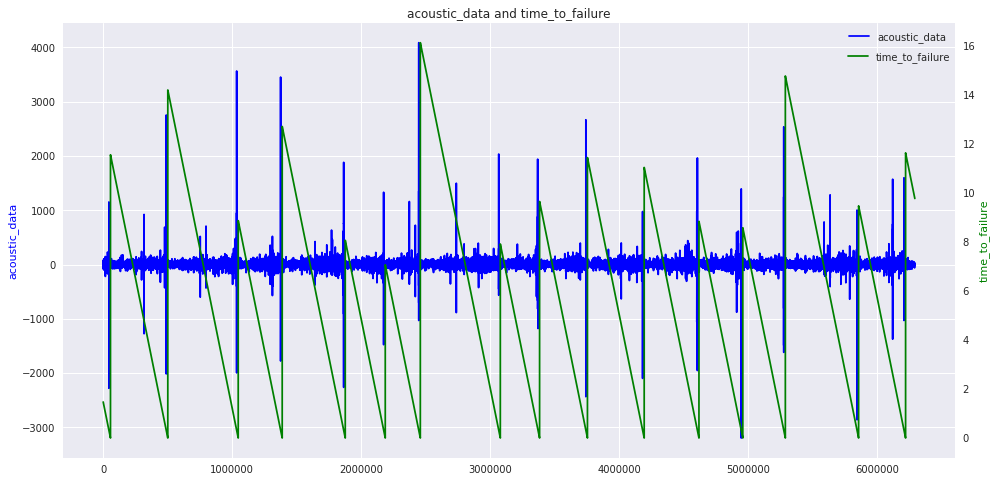

In [11]:
plot_acoustic_ttf(train)

### Locating Failures  
Locating where the failures occur in the dataset should help our analysis.  First a new column 'failure' is added to the dataframe that is true when a failure occurs and false otherwise.  Hopefully a clearer picture emerges when we zoom in on the graph and plot when failures occur.  

What becomes clear when you zoom in on the graph is that the acoustic data has a large peak shortly before the failures occur.  I suppose that must mean that this dataset is somehow labelled for when failures occur.  At first glance, it would appear that the time between when this large and failures is about the same for all of the failure cycles.  The length of each cycle can vary but this interval between peak acoustic and failure seems uniform.

There may also be an increasing trend in average magnitude of acoustic data as the cycle time increases.

It would be useful to look at each of these failures as seperate events by introducing new time variables: ts for the overall time since the experiment started, and ts_local for each of the failure cycles.  

In [12]:
def locate_failures(df, threshold = 1):
    """
    Locates where failures occur by finding local minima of time_to_failure
    A local minima is found wherever the diff of consecutive values exceeds a threshold,
    ie. where there is a jump
    A new dataframe is returned with a new boolean column 'failure'
    """
    # Turn off warning
    pd.options.mode.chained_assignment = None
    failures = df.loc[df['time_to_failure'].diff()>threshold].index-1
    df['failure'] = False
    df['failure'].loc[failures] = True
    return df

In [13]:
train = locate_failures(train)

In [14]:
def plot_acoustic_failure(df, nrows=1, interval=None):
    """
    Plots acoustic vs. failure
    nrows is the number of subplots
    interval is an integer row index tuple or list for rows of data you wish to plot
    
    In case I forget why I used squeeze and 2-D axes arrays:
    # https://stackoverflow.com/questions/19953348/error-when-looping-to-produce-subplots
    """

    if np.any(interval == None):
        interval = [0, len(df)-1]

    df = df.iloc[interval[0]:interval[1]]
    sub_length = int(len(df)/nrows)
    fig, axes = plt.subplots(nrows,1, sharey= True, figsize = (18,6*nrows), squeeze=False)
    for i in range(0,nrows):
        sub_range = range(i*sub_length,(i+1)*sub_length)
        axes[i,0].plot(df['acoustic_data'].iloc[sub_range], color = 'b')
        axes[i,0].grid(False)
        for failure in df.iloc[sub_range].loc[df['failure']==True].index:
            axes[i, 0].axvline(failure, color = 'r')
            
    return None

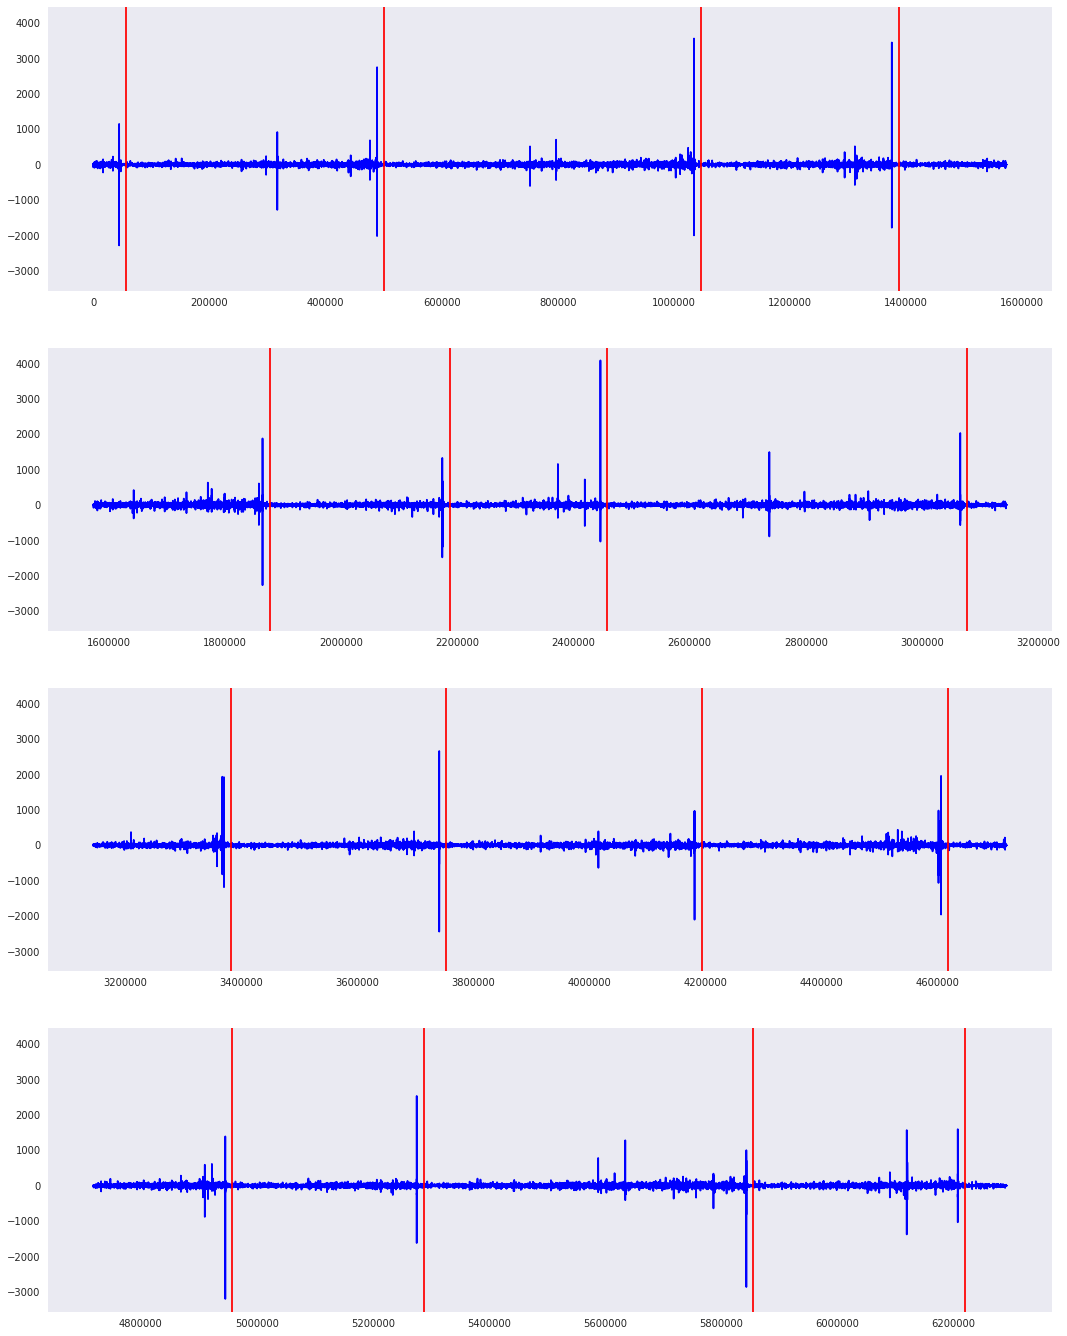

In [15]:
plot_acoustic_failure(train, nrows = 4)

In [16]:
def add_time_columns(df):
    df['ts_diff'] = -df['time_to_failure'].diff().fillna(0)
    failures = df.loc[df['failure']==True].index.tolist()

    for failure in failures:
        df['ts_diff'].iloc[failure+1] = df['ts_diff'].iloc[failure]
    df['ts'] = df['ts_diff'].cumsum()

    df['ts_diff'] = -df['time_to_failure'].diff().fillna(0)
    ttf = [0] + failures
    del ttf[-1]
    for i in range(len(failures)):
        df['ts_diff'].iloc[failures[i]+1] = -df['time_to_failure'].iloc[ttf[i]+1]

    df['ts_local'] = df['ts_diff'].cumsum()
    df.drop(['ts_diff'], axis = 1, inplace = True)
    
    return df

In [17]:
train = add_time_columns(train)
train.head()

,acoustic_data,time_to_failure,failure,ts,ts_local
0,9,1.469100,False,-0.000000e+00,-0.000000e+00
1,5,1.469100,False,1.100000e-07,1.100000e-07
2,0,1.469100,False,2.200000e-07,2.200000e-07
3,1,1.469100,False,3.300000e-07,3.300000e-07
4,1,1.469099,False,4.400000e-07,4.400000e-07


In [18]:
def plot_acoustic_failure_v2(df, nrows=1, interval=None):
    """
    Plots acoustic vs. failure
    nrows is the number of subplots
    interval is an integer row index tuple or list for rows of data you wish to plot
    
    In case I forget why I used squeeze and 2-D axes arrays:
    # https://stackoverflow.com/questions/19953348/error-when-looping-to-produce-subplots
    """

    if np.any(interval == None):
        interval = [0, len(df)-1]

    df = df.iloc[interval[0]:interval[1]]
    sub_length = int(len(df)/nrows)
    fig, axes = plt.subplots(nrows,1, sharey= True, figsize = (18,6*nrows), squeeze=False)
    for i in range(0,nrows):
        sub_range = range(i*sub_length,(i+1)*sub_length)
        axes[i,0].plot( df['ts'].iloc[sub_range], df['acoustic_data'].iloc[sub_range], color = 'b')
        axes[i,0].grid(False)
        for failure in df.iloc[sub_range].loc[df['failure']==True].index:
            axes[i, 0].axvline(df['ts'].iloc[failure], color = 'r')
            
    return None

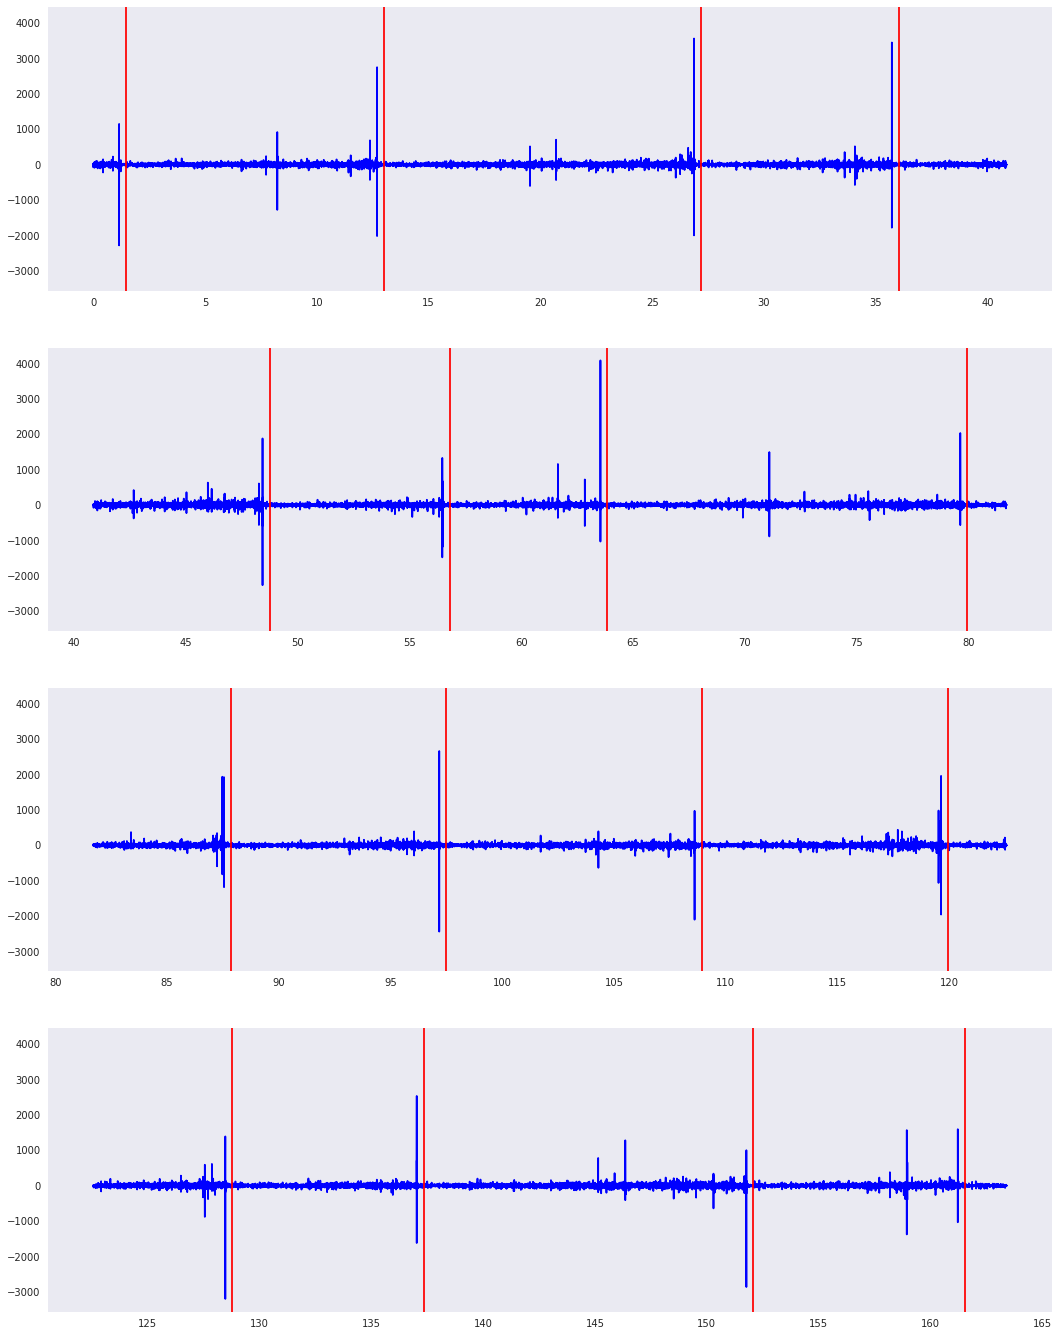

In [19]:
plot_acoustic_failure_v2(train, nrows = 4)